# HAR LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="../../data/har-data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="../../data/har-data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test) 

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train,
                                                random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [7]:
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 1000

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [9]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [10]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [11]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.847266 Train acc: 0.103333
Epoch: 1/1000 Iteration: 10 Train loss: 1.837416 Train acc: 0.121667
Epoch: 1/1000 Iteration: 15 Train loss: 1.835993 Train acc: 0.116667
Epoch: 2/1000 Iteration: 20 Train loss: 1.813084 Train acc: 0.160000
Epoch: 2/1000 Iteration: 25 Train loss: 1.809562 Train acc: 0.151667
Epoch: 2/1000 Iteration: 25 Validation loss: 1.796237 Validation acc: 0.161111
Epoch: 3/1000 Iteration: 30 Train loss: 1.797853 Train acc: 0.173333
Epoch: 3/1000 Iteration: 35 Train loss: 1.800327 Train acc: 0.161667
Epoch: 4/1000 Iteration: 40 Train loss: 1.766620 Train acc: 0.240000
Epoch: 4/1000 Iteration: 45 Train loss: 1.766606 Train acc: 0.235000
Epoch: 5/1000 Iteration: 50 Train loss: 1.744391 Train acc: 0.256667
Epoch: 5/1000 Iteration: 50 Validation loss: 1.742686 Validation acc: 0.326667
Epoch: 6/1000 Iteration: 55 Train loss: 1.748151 Train acc: 0.278333
Epoch: 6/1000 Iteration: 60 Train loss: 1.731008 Train acc: 0.311667
Epoch: 7/1000 I

Epoch: 53/1000 Iteration: 480 Train loss: 0.967682 Train acc: 0.628333
Epoch: 53/1000 Iteration: 485 Train loss: 0.899454 Train acc: 0.696667
Epoch: 54/1000 Iteration: 490 Train loss: 0.942367 Train acc: 0.645000
Epoch: 54/1000 Iteration: 495 Train loss: 0.906175 Train acc: 0.670000
Epoch: 55/1000 Iteration: 500 Train loss: 0.904765 Train acc: 0.681667
Epoch: 55/1000 Iteration: 500 Validation loss: 0.821274 Validation acc: 0.675000
Epoch: 56/1000 Iteration: 505 Train loss: 0.851567 Train acc: 0.691667
Epoch: 56/1000 Iteration: 510 Train loss: 0.870752 Train acc: 0.668333
Epoch: 57/1000 Iteration: 515 Train loss: 0.885930 Train acc: 0.651667
Epoch: 57/1000 Iteration: 520 Train loss: 0.906606 Train acc: 0.651667
Epoch: 58/1000 Iteration: 525 Train loss: 0.894072 Train acc: 0.635000
Epoch: 58/1000 Iteration: 525 Validation loss: 0.793299 Validation acc: 0.681111
Epoch: 58/1000 Iteration: 530 Train loss: 0.862010 Train acc: 0.666667
Epoch: 59/1000 Iteration: 535 Train loss: 0.890967 Train 

Epoch: 105/1000 Iteration: 950 Validation loss: 0.478959 Validation acc: 0.806667
Epoch: 106/1000 Iteration: 955 Train loss: 0.543131 Train acc: 0.806667
Epoch: 106/1000 Iteration: 960 Train loss: 0.532632 Train acc: 0.795000
Epoch: 107/1000 Iteration: 965 Train loss: 0.566969 Train acc: 0.798333
Epoch: 107/1000 Iteration: 970 Train loss: 0.558893 Train acc: 0.761667
Epoch: 108/1000 Iteration: 975 Train loss: 0.572440 Train acc: 0.780000
Epoch: 108/1000 Iteration: 975 Validation loss: 0.468253 Validation acc: 0.806111
Epoch: 108/1000 Iteration: 980 Train loss: 0.514854 Train acc: 0.835000
Epoch: 109/1000 Iteration: 985 Train loss: 0.573419 Train acc: 0.795000
Epoch: 109/1000 Iteration: 990 Train loss: 0.556118 Train acc: 0.798333
Epoch: 110/1000 Iteration: 995 Train loss: 0.539551 Train acc: 0.811667
Epoch: 111/1000 Iteration: 1000 Train loss: 0.529055 Train acc: 0.821667
Epoch: 111/1000 Iteration: 1000 Validation loss: 0.460305 Validation acc: 0.808333
Epoch: 111/1000 Iteration: 1005 

Epoch: 156/1000 Iteration: 1410 Train loss: 0.391348 Train acc: 0.831667
Epoch: 157/1000 Iteration: 1415 Train loss: 0.461262 Train acc: 0.795000
Epoch: 157/1000 Iteration: 1420 Train loss: 0.441010 Train acc: 0.826667
Epoch: 158/1000 Iteration: 1425 Train loss: 0.481783 Train acc: 0.795000
Epoch: 158/1000 Iteration: 1425 Validation loss: 0.357351 Validation acc: 0.836111
Epoch: 158/1000 Iteration: 1430 Train loss: 0.422833 Train acc: 0.835000
Epoch: 159/1000 Iteration: 1435 Train loss: 0.456751 Train acc: 0.821667
Epoch: 159/1000 Iteration: 1440 Train loss: 0.444896 Train acc: 0.825000
Epoch: 160/1000 Iteration: 1445 Train loss: 0.421713 Train acc: 0.835000
Epoch: 161/1000 Iteration: 1450 Train loss: 0.428455 Train acc: 0.840000
Epoch: 161/1000 Iteration: 1450 Validation loss: 0.352202 Validation acc: 0.843889
Epoch: 161/1000 Iteration: 1455 Train loss: 0.391306 Train acc: 0.846667
Epoch: 162/1000 Iteration: 1460 Train loss: 0.433121 Train acc: 0.828333
Epoch: 162/1000 Iteration: 1465

Epoch: 207/1000 Iteration: 1870 Train loss: 0.374840 Train acc: 0.893333
Epoch: 208/1000 Iteration: 1875 Train loss: 0.360467 Train acc: 0.891667
Epoch: 208/1000 Iteration: 1875 Validation loss: 0.265312 Validation acc: 0.921111
Epoch: 208/1000 Iteration: 1880 Train loss: 0.291478 Train acc: 0.923333
Epoch: 209/1000 Iteration: 1885 Train loss: 0.378859 Train acc: 0.895000
Epoch: 209/1000 Iteration: 1890 Train loss: 0.328964 Train acc: 0.903333
Epoch: 210/1000 Iteration: 1895 Train loss: 0.321303 Train acc: 0.908333
Epoch: 211/1000 Iteration: 1900 Train loss: 0.335599 Train acc: 0.910000
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.258850 Validation acc: 0.924444
Epoch: 211/1000 Iteration: 1905 Train loss: 0.310507 Train acc: 0.906667
Epoch: 212/1000 Iteration: 1910 Train loss: 0.332957 Train acc: 0.923333
Epoch: 212/1000 Iteration: 1915 Train loss: 0.290689 Train acc: 0.930000
Epoch: 213/1000 Iteration: 1920 Train loss: 0.350594 Train acc: 0.908333
Epoch: 213/1000 Iteration: 1925

Epoch: 258/1000 Iteration: 2325 Validation loss: 0.166826 Validation acc: 0.951111
Epoch: 258/1000 Iteration: 2330 Train loss: 0.200442 Train acc: 0.960000
Epoch: 259/1000 Iteration: 2335 Train loss: 0.261164 Train acc: 0.918333
Epoch: 259/1000 Iteration: 2340 Train loss: 0.240039 Train acc: 0.950000
Epoch: 260/1000 Iteration: 2345 Train loss: 0.233210 Train acc: 0.935000
Epoch: 261/1000 Iteration: 2350 Train loss: 0.237820 Train acc: 0.941667
Epoch: 261/1000 Iteration: 2350 Validation loss: 0.167731 Validation acc: 0.952222
Epoch: 261/1000 Iteration: 2355 Train loss: 0.220885 Train acc: 0.953333
Epoch: 262/1000 Iteration: 2360 Train loss: 0.248073 Train acc: 0.948333
Epoch: 262/1000 Iteration: 2365 Train loss: 0.212736 Train acc: 0.958333
Epoch: 263/1000 Iteration: 2370 Train loss: 0.235305 Train acc: 0.938333
Epoch: 263/1000 Iteration: 2375 Train loss: 0.191851 Train acc: 0.961667
Epoch: 263/1000 Iteration: 2375 Validation loss: 0.161218 Validation acc: 0.953889
Epoch: 264/1000 Itera

Epoch: 309/1000 Iteration: 2785 Train loss: 0.236813 Train acc: 0.936667
Epoch: 309/1000 Iteration: 2790 Train loss: 0.193566 Train acc: 0.956667
Epoch: 310/1000 Iteration: 2795 Train loss: 0.188792 Train acc: 0.943333
Epoch: 311/1000 Iteration: 2800 Train loss: 0.203523 Train acc: 0.956667
Epoch: 311/1000 Iteration: 2800 Validation loss: 0.139508 Validation acc: 0.954444
Epoch: 311/1000 Iteration: 2805 Train loss: 0.159730 Train acc: 0.955000
Epoch: 312/1000 Iteration: 2810 Train loss: 0.186635 Train acc: 0.961667
Epoch: 312/1000 Iteration: 2815 Train loss: 0.185369 Train acc: 0.960000
Epoch: 313/1000 Iteration: 2820 Train loss: 0.207473 Train acc: 0.941667
Epoch: 313/1000 Iteration: 2825 Train loss: 0.144561 Train acc: 0.968333
Epoch: 313/1000 Iteration: 2825 Validation loss: 0.135679 Validation acc: 0.955000
Epoch: 314/1000 Iteration: 2830 Train loss: 0.221882 Train acc: 0.951667
Epoch: 314/1000 Iteration: 2835 Train loss: 0.204534 Train acc: 0.953333
Epoch: 315/1000 Iteration: 2840

Epoch: 360/1000 Iteration: 3245 Train loss: 0.161787 Train acc: 0.956667
Epoch: 361/1000 Iteration: 3250 Train loss: 0.166519 Train acc: 0.965000
Epoch: 361/1000 Iteration: 3250 Validation loss: 0.127412 Validation acc: 0.956667
Epoch: 361/1000 Iteration: 3255 Train loss: 0.133151 Train acc: 0.968333
Epoch: 362/1000 Iteration: 3260 Train loss: 0.188345 Train acc: 0.970000
Epoch: 362/1000 Iteration: 3265 Train loss: 0.179469 Train acc: 0.960000
Epoch: 363/1000 Iteration: 3270 Train loss: 0.199520 Train acc: 0.935000
Epoch: 363/1000 Iteration: 3275 Train loss: 0.154146 Train acc: 0.963333
Epoch: 363/1000 Iteration: 3275 Validation loss: 0.138872 Validation acc: 0.955555
Epoch: 364/1000 Iteration: 3280 Train loss: 0.194336 Train acc: 0.945000
Epoch: 364/1000 Iteration: 3285 Train loss: 0.177953 Train acc: 0.948333
Epoch: 365/1000 Iteration: 3290 Train loss: 0.165172 Train acc: 0.963333
Epoch: 366/1000 Iteration: 3295 Train loss: 0.169019 Train acc: 0.955000
Epoch: 366/1000 Iteration: 3300

Epoch: 411/1000 Iteration: 3700 Validation loss: 0.125077 Validation acc: 0.956667
Epoch: 411/1000 Iteration: 3705 Train loss: 0.138551 Train acc: 0.960000
Epoch: 412/1000 Iteration: 3710 Train loss: 0.156349 Train acc: 0.961667
Epoch: 412/1000 Iteration: 3715 Train loss: 0.151385 Train acc: 0.961667
Epoch: 413/1000 Iteration: 3720 Train loss: 0.168740 Train acc: 0.948333
Epoch: 413/1000 Iteration: 3725 Train loss: 0.108639 Train acc: 0.981667
Epoch: 413/1000 Iteration: 3725 Validation loss: 0.118249 Validation acc: 0.958333
Epoch: 414/1000 Iteration: 3730 Train loss: 0.192986 Train acc: 0.941667
Epoch: 414/1000 Iteration: 3735 Train loss: 0.149777 Train acc: 0.960000
Epoch: 415/1000 Iteration: 3740 Train loss: 0.142111 Train acc: 0.965000
Epoch: 416/1000 Iteration: 3745 Train loss: 0.154659 Train acc: 0.963333
Epoch: 416/1000 Iteration: 3750 Train loss: 0.140313 Train acc: 0.963333
Epoch: 416/1000 Iteration: 3750 Validation loss: 0.121139 Validation acc: 0.955000
Epoch: 417/1000 Itera

Epoch: 462/1000 Iteration: 4160 Train loss: 0.139574 Train acc: 0.968333
Epoch: 462/1000 Iteration: 4165 Train loss: 0.140845 Train acc: 0.971667
Epoch: 463/1000 Iteration: 4170 Train loss: 0.154078 Train acc: 0.955000
Epoch: 463/1000 Iteration: 4175 Train loss: 0.103763 Train acc: 0.975000
Epoch: 463/1000 Iteration: 4175 Validation loss: 0.114910 Validation acc: 0.957222
Epoch: 464/1000 Iteration: 4180 Train loss: 0.177987 Train acc: 0.951667
Epoch: 464/1000 Iteration: 4185 Train loss: 0.132762 Train acc: 0.970000
Epoch: 465/1000 Iteration: 4190 Train loss: 0.138813 Train acc: 0.963333
Epoch: 466/1000 Iteration: 4195 Train loss: 0.141381 Train acc: 0.960000
Epoch: 466/1000 Iteration: 4200 Train loss: 0.126855 Train acc: 0.963333
Epoch: 466/1000 Iteration: 4200 Validation loss: 0.114304 Validation acc: 0.956667
Epoch: 467/1000 Iteration: 4205 Train loss: 0.115830 Train acc: 0.976667
Epoch: 467/1000 Iteration: 4210 Train loss: 0.135692 Train acc: 0.961667
Epoch: 468/1000 Iteration: 4215

Epoch: 513/1000 Iteration: 4620 Train loss: 0.169250 Train acc: 0.951667
Epoch: 513/1000 Iteration: 4625 Train loss: 0.107883 Train acc: 0.978333
Epoch: 513/1000 Iteration: 4625 Validation loss: 0.113450 Validation acc: 0.956667
Epoch: 514/1000 Iteration: 4630 Train loss: 0.153083 Train acc: 0.955000
Epoch: 514/1000 Iteration: 4635 Train loss: 0.146733 Train acc: 0.958333
Epoch: 515/1000 Iteration: 4640 Train loss: 0.141497 Train acc: 0.968333
Epoch: 516/1000 Iteration: 4645 Train loss: 0.134365 Train acc: 0.963333
Epoch: 516/1000 Iteration: 4650 Train loss: 0.120043 Train acc: 0.960000
Epoch: 516/1000 Iteration: 4650 Validation loss: 0.110491 Validation acc: 0.957222
Epoch: 517/1000 Iteration: 4655 Train loss: 0.123814 Train acc: 0.973333
Epoch: 517/1000 Iteration: 4660 Train loss: 0.127805 Train acc: 0.975000
Epoch: 518/1000 Iteration: 4665 Train loss: 0.128355 Train acc: 0.965000
Epoch: 518/1000 Iteration: 4670 Train loss: 0.105753 Train acc: 0.976667
Epoch: 519/1000 Iteration: 4675

Epoch: 563/1000 Iteration: 5075 Validation loss: 0.114350 Validation acc: 0.957222
Epoch: 564/1000 Iteration: 5080 Train loss: 0.131810 Train acc: 0.961667
Epoch: 564/1000 Iteration: 5085 Train loss: 0.129228 Train acc: 0.965000
Epoch: 565/1000 Iteration: 5090 Train loss: 0.128764 Train acc: 0.955000
Epoch: 566/1000 Iteration: 5095 Train loss: 0.131099 Train acc: 0.965000
Epoch: 566/1000 Iteration: 5100 Train loss: 0.108506 Train acc: 0.973333
Epoch: 566/1000 Iteration: 5100 Validation loss: 0.114440 Validation acc: 0.957222
Epoch: 567/1000 Iteration: 5105 Train loss: 0.132949 Train acc: 0.970000
Epoch: 567/1000 Iteration: 5110 Train loss: 0.112007 Train acc: 0.976667
Epoch: 568/1000 Iteration: 5115 Train loss: 0.124027 Train acc: 0.961667
Epoch: 568/1000 Iteration: 5120 Train loss: 0.102384 Train acc: 0.978333
Epoch: 569/1000 Iteration: 5125 Train loss: 0.144875 Train acc: 0.955000
Epoch: 569/1000 Iteration: 5125 Validation loss: 0.106697 Validation acc: 0.959444
Epoch: 569/1000 Itera

Epoch: 614/1000 Iteration: 5535 Train loss: 0.144728 Train acc: 0.961667
Epoch: 615/1000 Iteration: 5540 Train loss: 0.130321 Train acc: 0.951667
Epoch: 616/1000 Iteration: 5545 Train loss: 0.112089 Train acc: 0.970000
Epoch: 616/1000 Iteration: 5550 Train loss: 0.094394 Train acc: 0.973333
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.106404 Validation acc: 0.957778
Epoch: 617/1000 Iteration: 5555 Train loss: 0.127580 Train acc: 0.970000
Epoch: 617/1000 Iteration: 5560 Train loss: 0.134842 Train acc: 0.966667
Epoch: 618/1000 Iteration: 5565 Train loss: 0.142790 Train acc: 0.946667
Epoch: 618/1000 Iteration: 5570 Train loss: 0.108339 Train acc: 0.980000
Epoch: 619/1000 Iteration: 5575 Train loss: 0.153462 Train acc: 0.950000
Epoch: 619/1000 Iteration: 5575 Validation loss: 0.114463 Validation acc: 0.956111
Epoch: 619/1000 Iteration: 5580 Train loss: 0.130297 Train acc: 0.963333
Epoch: 620/1000 Iteration: 5585 Train loss: 0.147740 Train acc: 0.948333
Epoch: 621/1000 Iteration: 5590

Epoch: 666/1000 Iteration: 5995 Train loss: 0.115506 Train acc: 0.970000
Epoch: 666/1000 Iteration: 6000 Train loss: 0.098713 Train acc: 0.971667
Epoch: 666/1000 Iteration: 6000 Validation loss: 0.116038 Validation acc: 0.957778
Epoch: 667/1000 Iteration: 6005 Train loss: 0.115310 Train acc: 0.968333
Epoch: 667/1000 Iteration: 6010 Train loss: 0.126989 Train acc: 0.973333
Epoch: 668/1000 Iteration: 6015 Train loss: 0.106171 Train acc: 0.966667
Epoch: 668/1000 Iteration: 6020 Train loss: 0.081475 Train acc: 0.976667
Epoch: 669/1000 Iteration: 6025 Train loss: 0.134140 Train acc: 0.953333
Epoch: 669/1000 Iteration: 6025 Validation loss: 0.114911 Validation acc: 0.957222
Epoch: 669/1000 Iteration: 6030 Train loss: 0.121487 Train acc: 0.963333
Epoch: 670/1000 Iteration: 6035 Train loss: 0.141635 Train acc: 0.956667
Epoch: 671/1000 Iteration: 6040 Train loss: 0.095408 Train acc: 0.973333
Epoch: 671/1000 Iteration: 6045 Train loss: 0.109781 Train acc: 0.963333
Epoch: 672/1000 Iteration: 6050

Epoch: 716/1000 Iteration: 6450 Validation loss: 0.109958 Validation acc: 0.957778
Epoch: 717/1000 Iteration: 6455 Train loss: 0.098958 Train acc: 0.976667
Epoch: 717/1000 Iteration: 6460 Train loss: 0.106209 Train acc: 0.978333
Epoch: 718/1000 Iteration: 6465 Train loss: 0.134670 Train acc: 0.956667
Epoch: 718/1000 Iteration: 6470 Train loss: 0.082931 Train acc: 0.978333
Epoch: 719/1000 Iteration: 6475 Train loss: 0.126123 Train acc: 0.956667
Epoch: 719/1000 Iteration: 6475 Validation loss: 0.111334 Validation acc: 0.957778
Epoch: 719/1000 Iteration: 6480 Train loss: 0.131579 Train acc: 0.960000
Epoch: 720/1000 Iteration: 6485 Train loss: 0.115124 Train acc: 0.961667
Epoch: 721/1000 Iteration: 6490 Train loss: 0.118770 Train acc: 0.963333
Epoch: 721/1000 Iteration: 6495 Train loss: 0.084985 Train acc: 0.973333
Epoch: 722/1000 Iteration: 6500 Train loss: 0.110475 Train acc: 0.971667
Epoch: 722/1000 Iteration: 6500 Validation loss: 0.113131 Validation acc: 0.957222
Epoch: 722/1000 Itera

Epoch: 767/1000 Iteration: 6910 Train loss: 0.099026 Train acc: 0.971667
Epoch: 768/1000 Iteration: 6915 Train loss: 0.135662 Train acc: 0.953333
Epoch: 768/1000 Iteration: 6920 Train loss: 0.080124 Train acc: 0.978333
Epoch: 769/1000 Iteration: 6925 Train loss: 0.144548 Train acc: 0.953333
Epoch: 769/1000 Iteration: 6925 Validation loss: 0.108847 Validation acc: 0.960000
Epoch: 769/1000 Iteration: 6930 Train loss: 0.110658 Train acc: 0.968333
Epoch: 770/1000 Iteration: 6935 Train loss: 0.105153 Train acc: 0.965000
Epoch: 771/1000 Iteration: 6940 Train loss: 0.109994 Train acc: 0.963333
Epoch: 771/1000 Iteration: 6945 Train loss: 0.076008 Train acc: 0.980000
Epoch: 772/1000 Iteration: 6950 Train loss: 0.115107 Train acc: 0.970000
Epoch: 772/1000 Iteration: 6950 Validation loss: 0.117221 Validation acc: 0.956667
Epoch: 772/1000 Iteration: 6955 Train loss: 0.111522 Train acc: 0.973333
Epoch: 773/1000 Iteration: 6960 Train loss: 0.106629 Train acc: 0.970000
Epoch: 773/1000 Iteration: 6965

Epoch: 818/1000 Iteration: 7370 Train loss: 0.080547 Train acc: 0.973333
Epoch: 819/1000 Iteration: 7375 Train loss: 0.140783 Train acc: 0.953333
Epoch: 819/1000 Iteration: 7375 Validation loss: 0.114804 Validation acc: 0.957778
Epoch: 819/1000 Iteration: 7380 Train loss: 0.110343 Train acc: 0.973333
Epoch: 820/1000 Iteration: 7385 Train loss: 0.110312 Train acc: 0.963333
Epoch: 821/1000 Iteration: 7390 Train loss: 0.103949 Train acc: 0.971667
Epoch: 821/1000 Iteration: 7395 Train loss: 0.094364 Train acc: 0.958333
Epoch: 822/1000 Iteration: 7400 Train loss: 0.105961 Train acc: 0.973333
Epoch: 822/1000 Iteration: 7400 Validation loss: 0.112975 Validation acc: 0.957222
Epoch: 822/1000 Iteration: 7405 Train loss: 0.100038 Train acc: 0.973333
Epoch: 823/1000 Iteration: 7410 Train loss: 0.139501 Train acc: 0.955000
Epoch: 823/1000 Iteration: 7415 Train loss: 0.073744 Train acc: 0.981667
Epoch: 824/1000 Iteration: 7420 Train loss: 0.138117 Train acc: 0.955000
Epoch: 824/1000 Iteration: 7425

Epoch: 869/1000 Iteration: 7825 Validation loss: 0.110326 Validation acc: 0.957222
Epoch: 869/1000 Iteration: 7830 Train loss: 0.121809 Train acc: 0.958333
Epoch: 870/1000 Iteration: 7835 Train loss: 0.097851 Train acc: 0.963333
Epoch: 871/1000 Iteration: 7840 Train loss: 0.097426 Train acc: 0.961667
Epoch: 871/1000 Iteration: 7845 Train loss: 0.075158 Train acc: 0.978333
Epoch: 872/1000 Iteration: 7850 Train loss: 0.103043 Train acc: 0.973333
Epoch: 872/1000 Iteration: 7850 Validation loss: 0.108186 Validation acc: 0.958333
Epoch: 872/1000 Iteration: 7855 Train loss: 0.089801 Train acc: 0.973333
Epoch: 873/1000 Iteration: 7860 Train loss: 0.114144 Train acc: 0.961667
Epoch: 873/1000 Iteration: 7865 Train loss: 0.078641 Train acc: 0.978333
Epoch: 874/1000 Iteration: 7870 Train loss: 0.113805 Train acc: 0.965000
Epoch: 874/1000 Iteration: 7875 Train loss: 0.119305 Train acc: 0.956667
Epoch: 874/1000 Iteration: 7875 Validation loss: 0.107142 Validation acc: 0.958333
Epoch: 875/1000 Itera

Epoch: 920/1000 Iteration: 8285 Train loss: 0.106522 Train acc: 0.965000
Epoch: 921/1000 Iteration: 8290 Train loss: 0.091879 Train acc: 0.971667
Epoch: 921/1000 Iteration: 8295 Train loss: 0.087938 Train acc: 0.966667
Epoch: 922/1000 Iteration: 8300 Train loss: 0.102484 Train acc: 0.971667
Epoch: 922/1000 Iteration: 8300 Validation loss: 0.106857 Validation acc: 0.960000
Epoch: 922/1000 Iteration: 8305 Train loss: 0.097596 Train acc: 0.970000
Epoch: 923/1000 Iteration: 8310 Train loss: 0.140733 Train acc: 0.953333
Epoch: 923/1000 Iteration: 8315 Train loss: 0.075315 Train acc: 0.981667
Epoch: 924/1000 Iteration: 8320 Train loss: 0.127621 Train acc: 0.960000
Epoch: 924/1000 Iteration: 8325 Train loss: 0.113094 Train acc: 0.968333
Epoch: 924/1000 Iteration: 8325 Validation loss: 0.105786 Validation acc: 0.961111
Epoch: 925/1000 Iteration: 8330 Train loss: 0.117161 Train acc: 0.966667
Epoch: 926/1000 Iteration: 8335 Train loss: 0.086715 Train acc: 0.973333
Epoch: 926/1000 Iteration: 8340

Epoch: 971/1000 Iteration: 8745 Train loss: 0.078261 Train acc: 0.970000
Epoch: 972/1000 Iteration: 8750 Train loss: 0.119227 Train acc: 0.961667
Epoch: 972/1000 Iteration: 8750 Validation loss: 0.108460 Validation acc: 0.958333
Epoch: 972/1000 Iteration: 8755 Train loss: 0.081248 Train acc: 0.971667
Epoch: 973/1000 Iteration: 8760 Train loss: 0.101114 Train acc: 0.963333
Epoch: 973/1000 Iteration: 8765 Train loss: 0.079321 Train acc: 0.980000
Epoch: 974/1000 Iteration: 8770 Train loss: 0.129351 Train acc: 0.956667
Epoch: 974/1000 Iteration: 8775 Train loss: 0.101454 Train acc: 0.968333
Epoch: 974/1000 Iteration: 8775 Validation loss: 0.106993 Validation acc: 0.957222
Epoch: 975/1000 Iteration: 8780 Train loss: 0.089833 Train acc: 0.970000
Epoch: 976/1000 Iteration: 8785 Train loss: 0.083679 Train acc: 0.968333
Epoch: 976/1000 Iteration: 8790 Train loss: 0.079962 Train acc: 0.973333
Epoch: 977/1000 Iteration: 8795 Train loss: 0.082398 Train acc: 0.978333
Epoch: 977/1000 Iteration: 8800

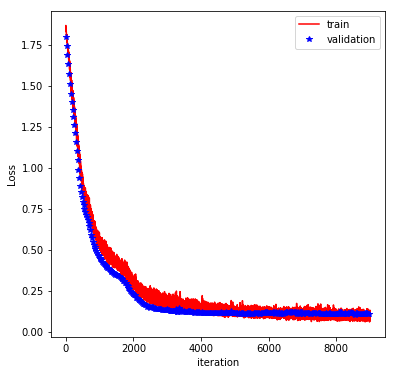

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

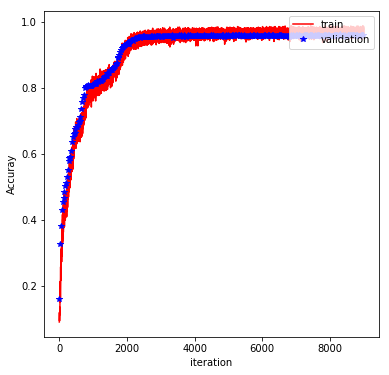

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Test accuracy: 0.861667
